# Final Project

### Overview

We have found a 30GB uncompressed dataset from reddit comments from 05/2015. We will upload it into the amazon server, as we applied for AWS Educate application and has been approved. We hope to play around with the dataset remotely with BLAZE, create a bag-of-words, process words ordered by time in order to do sentiment analysis using the LabMT wordlist, create WordCloud for specific topics like 'Deep Learning' or ‘Big Data’, and finally predict if a comment has the subreddit ‘Big_Data’ using ML technics learned in class. 

In [6]:
# import libraries
from IPython.display import Image

## Step 1 - Prepare the remote access

##### Create instance in AWS amazon server environment and upload the dataset. Make sure to request enough space for the data and the castra file to fit in the volume.

In [ ]:
# Log into the EC2 instance created
ssh -i "~/.ssh/MyFirstKey.pem" ubuntu@ec2-54-165-250-39.compute-1.amazonaws.com

In [4]:
Image(filename='photos/1.png')

In [ ]:
# Upload the dataset to the instance
scp -i ~/.ssh/MyFirstKey.pem ~/Documents/DTU/Computational_Tools_for_Big_Data/Final_Project/RC_2015-01.bz2 ubuntu@ec2-54-165-250-39.compute-1.amazonaws.com:~/data/RC_2015-01.bz2

In [5]:
Image(filename='photos/2.png')

#### Install all dependencies to the instance in order to wrangle the data from distance. Firstly we need to download Anaconda to the instance. 

In [ ]:
# Download Anaconda to the server
wget https://repo.continuum.io/archive/Anaconda2-4.2.0-Linux-x86_64.sh

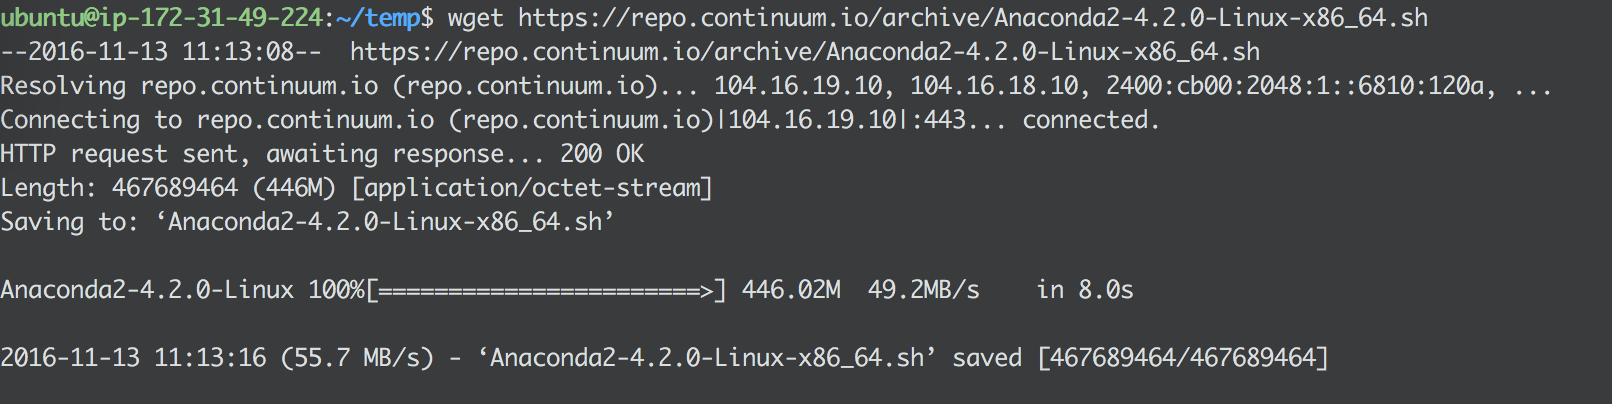

In [6]:
Image(filename='photos/3.png')

In [ ]:
# Install Anaconda to the instance
bash Anaconda2-4.2.0-Linux-x86_64.sh

In [7]:
Image(filename='photos/4.png')

#### Settle a server ipython notebook for remote handling python reports and querying data

In [ ]:
# Open ipython in server environment and do the following command
ipython

# It will prompt a python interactive window that works in the bash environment
# Then create a password by typing the below commands
from IPython.lib import passwd
passwd()

# You will be prompted to enter and verify a password (You should remember it. This will be the password to log 
# to the remote ipython notebook)
# When done copy the generated sha1 key

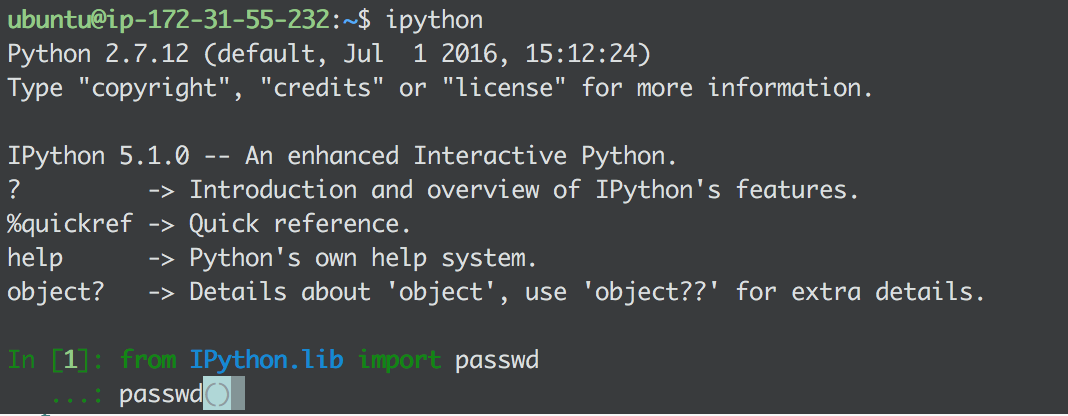

In [4]:
Image(filename='photos/30.png')

In [ ]:
# Locate the ipython_notebook_config.py file in the .jupyter directory and paste the key in the
# appropriate field along with the rest of the uncommented lines.

# If you don't already have a ipython_notebook_config.py file create one using the command below
jupyter notebook --generate-config

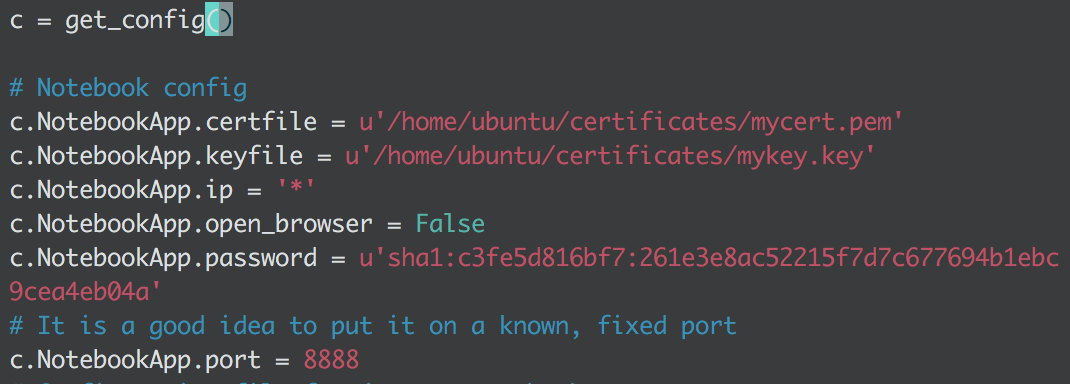

In [5]:
Image(filename='photos/31.png')

In [ ]:
# Now the connection is established. Write the below command to launch ipython
ipython notebook

In [ ]:
# You will be prompted to open a browser and on the command write
# https://[ip adress of the server]:[port]
https://ec2-54-144-210-190.compute-1.amazonaws.com:8888/

In [6]:
Image(filename='photos/32.png')

## Step 2 - Prepare the local environment

#### Download and install anaconda-client and anaconda cluster locally

In [ ]:
# Download and install anaconda-client locally
conda install anaconda-client

# Login to Anaconda cloud
sudo anaconda login

In [10]:
Image(filename='photos/6.png')

In [ ]:
# Download and install anaconda-cluster locally
sudo conda install anaconda-cluster -c anaconda-cluster

# Initialize anaconda-cluster
acluster

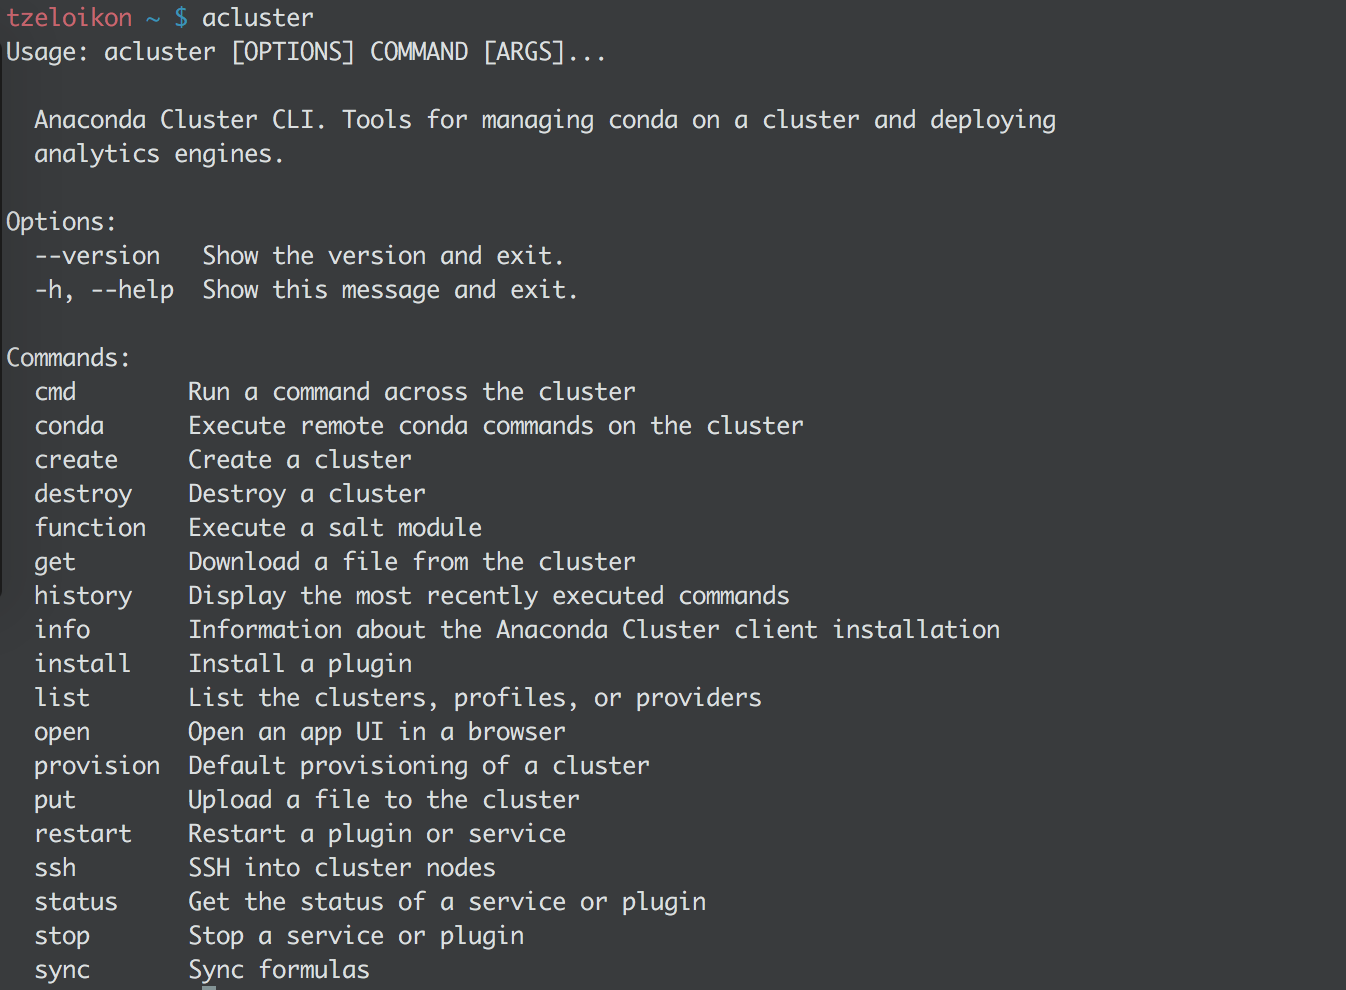

In [11]:
Image(filename='photos/7.png')

#### Create an image(AMI) from the AWS console in order for the anaconda-cluster to launch a new instance

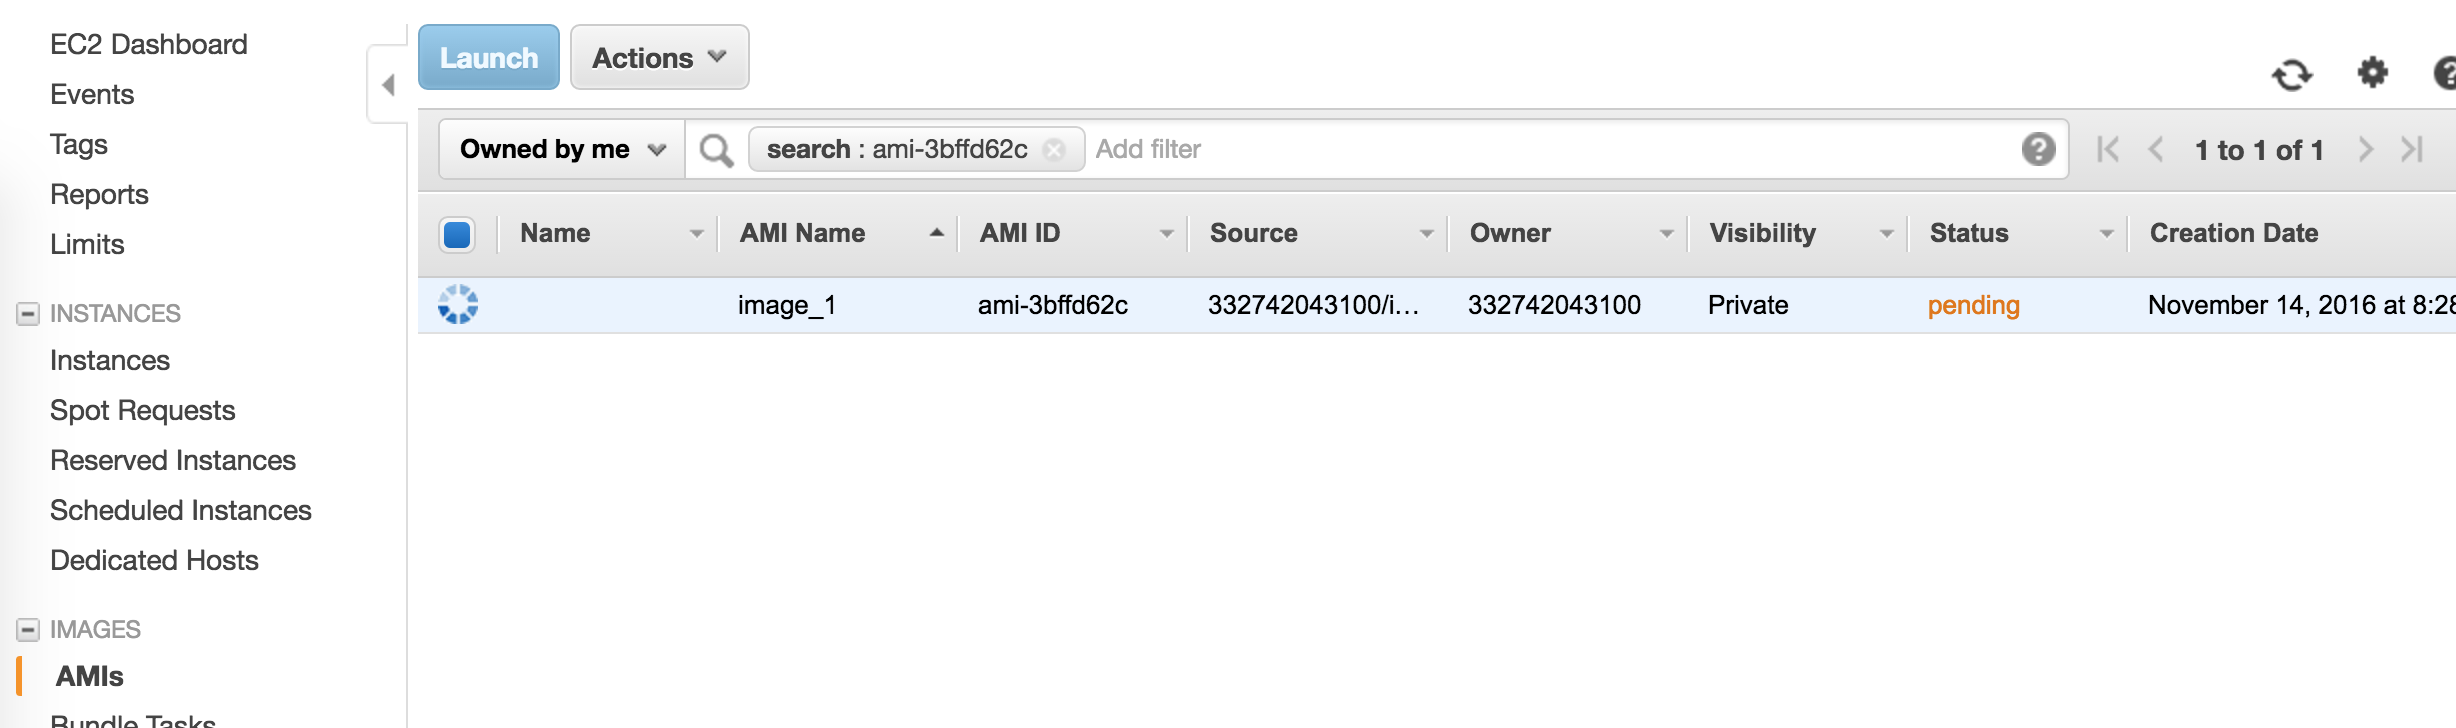

In [3]:
Image(filename='photos/10.png')

#### Edit the providers file

In [ ]:
# Open the file with an editor and change it
subl ~/.acluster/providers.yaml

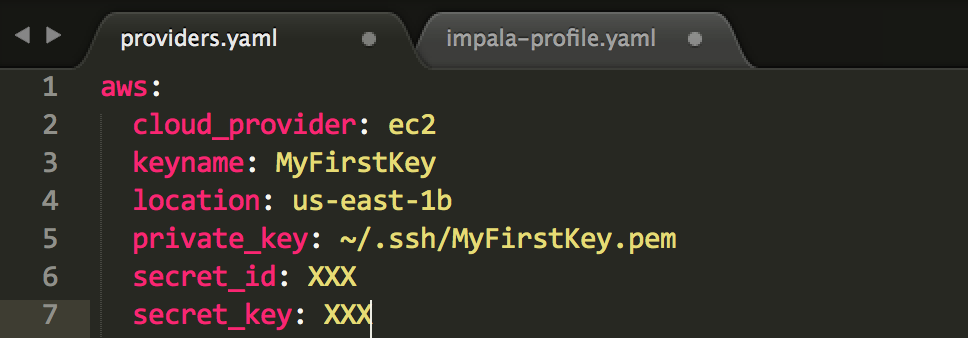

In [4]:
Image(filename='photos/12.png')

#### Create a new profile file and assign the info that you want your image to have

In [ ]:
# Open the file with an editor and change it
subl ~/.acluster/profiles.d/profile_1.yaml

In [6]:
Image(filename='photos/14.png')

#### Now that we have everything set, we will create the anaconda cluster remotely

In [ ]:
# Use the below command locally
acluster create impala-cluster -p impala-profile

In [9]:
Image(filename='photos/16.png')

#### Later we will set up a password-less ssh login for the cluster because it gives permission denied messages in -conda commands

In [ ]:
# Create public/private key-pair
ssh-keygen

In [10]:
Image(filename='photos/17.png')

In [ ]:
# Copy the generated key to the remote server you want to setup passwordless logins with
cat ~/.ssh/id_rsa.pub | ssh -i "~/.ssh/MyFirstKey.pem" ubuntu@ec2-54-144-210-190.compute-1.amazonaws.com 'cat >> ~/.ssh/authorized_keys'

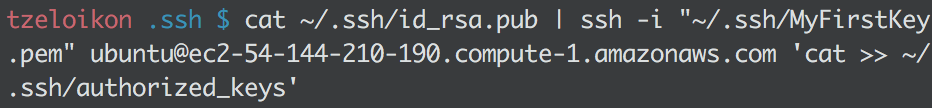

In [11]:
Image(filename='photos/18.png')

Now we can give commands to the server with acluster -conda without even logging in and without any ssh key mentioned!

#### Create an environment.yml file locally which will be used to install all the appropriate packages for the remote wrangling. 
*Warning!! Commands concerning this environment should be given from the same directory where the file is saved. *
*Warning_2!! All of the packages mentione have to be installed localy first before you create the evironment*

In [ ]:
# Setup configurable sessions. Create a new conda environment_2.yml file
cat > environment.yml <<EOF
 name: blaze-impala
 channels:
   - blaze
 dependencies:
   - blaze
   - bokeh=0.9
   - impyla
   - jupyter
   - pandas
   - pyhive
   - python=2.7
   - bz2
   - castra
   - dask
   - praw
   - re
   - nltk
   - wordcloud
   - numpy
EOF

#### Now create the environment remotely for the server using -conda and activate it

In [ ]:
# Create environment
sudo conda env create

In [19]:
Image(filename='photos/20.png')

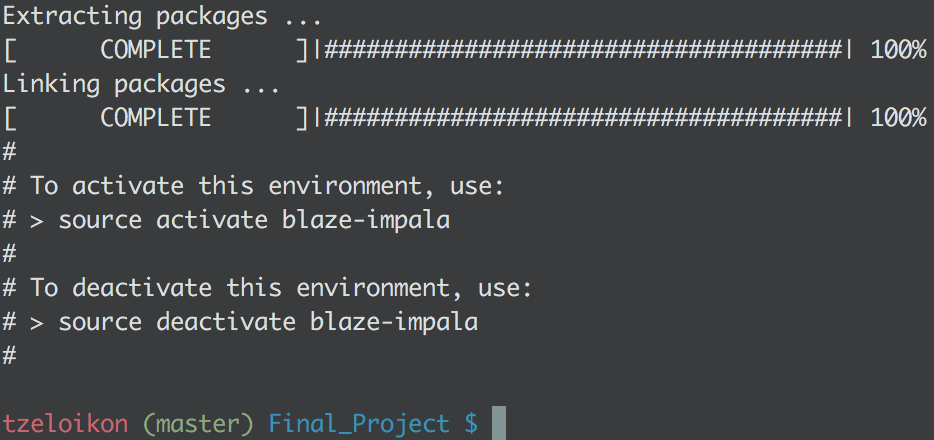

In [20]:
Image(filename='photos/21.png')

In [21]:
# Activate environment
source activate blaze-impala

# Deactivate environment when done
source deactivate blaze-impala

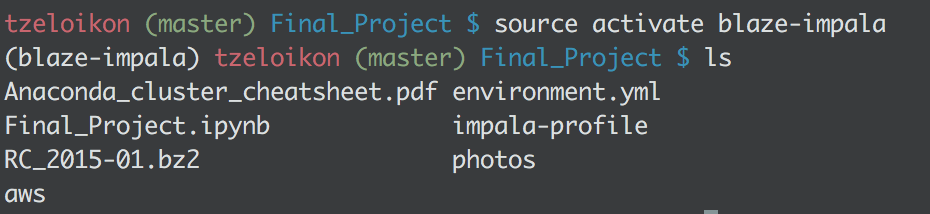

In [22]:
Image(filename='photos/22.png')

## Step 3 - Extract data and start data wrangling

Now that we have set all up, we are ready to parse the data with ipython notebook remotely. We will use Dask and Castra because Impala and Blaze didn't work for some reason. From now on we write code directly to server's notebook as mentioned on step 1

Firstly we will examin a line of the dataset with the help of bz2 to parse the compressed file and ujson to load the line.

In [32]:
# Load all libraries used
from bz2 import BZ2File
import ujson
import json
import re
import pandas as pd
from pandas import Timestamp, NaT, DataFrame
from toolz import dissoc
from castra import Castra
from toolz import peek, partition_all
import time
import datetime
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.diagnostics import visualize
from dask.diagnostics import ResourceProfiler
import numpy as np
import nltk
from nltk.corpus import stopwords
import dask.bag as db
from bokeh.charts import TimeSeries, output_notebook, show
from string import punctuation
from itertools import izip
import matplotlib.pyplot as plt
import math
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

In [2]:
with BZ2File('data/RC_2015-01.bz2') as f:
    line = f.readline()
ujson.loads(line)

{u'archived': False,
 u'author': u'YoungModern',
 u'author_flair_css_class': None,
 u'author_flair_text': None,
 u'body': u'Most of us have some family members like this. *Most* of my family is like this. ',
 u'controversiality': 0,
 u'created_utc': u'1420070400',
 u'distinguished': None,
 u'downs': 0,
 u'edited': False,
 u'gilded': 0,
 u'id': u'cnas8zv',
 u'link_id': u't3_2qyr1a',
 u'name': u't1_cnas8zv',
 u'parent_id': u't3_2qyr1a',
 u'retrieved_on': 1425124282,
 u'score': 14,
 u'score_hidden': False,
 u'subreddit': u'exmormon',
 u'subreddit_id': u't5_2r0gj',
 u'ups': 14}

The below block of code is inspred and most of it used by this tutorial for Castra: http://blaze.pydata.org/blog/2015/09/08/reddit-comments/

Now we should create the castra file to parse data on the disk and not on the memory as the memory is not enough to handle such volumes of data.

In [3]:
# Create a path for locating the data files
path = 'data/'
raw_file = 'RC_2015-01.bz2'

# Give a number of lines processed per attempt
# Use a small number because of the small memory size(1GB) of the instance
lppa = 20000

Create functions that will handle the transformation of the json bz2 file into castra files

In [4]:
#Convert a line of JSON(post) into a cleaned up dict.
def to_json(line):
    post = ujson.loads(line)
    
    # Convert timestamps into Timestamp objects. 
    # It will help us create the sentiment analysis over time
    date = post['created_utc']
    post['created_utc'] = Timestamp.utcfromtimestamp(int(date))
    edited = post['edited']
    post['edited'] = Timestamp.utcfromtimestamp(int(edited)) if edited else NaT
    
    # Convert deleted posts into None values
    if post['author'] == '[deleted]':
        post['author'] = None
    if post['body'] == '[deleted]':
        post['body'] = None
        
    # Remove 'id', and 'subreddit_id' as they're redundant
    # Remove 'retrieved_on' as it's irrelevant
    return dissoc(post, 'id', 'subreddit_id', 'retrieved_on')
    

# Store the column names for each post in a variable
columns = ['archived', 'author', 'author_flair_css_class', 'author_flair_text',
           'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
           'edited', 'gilded', 'link_id', 'name', 'parent_id',
           'removal_reason', 'score', 'score_hidden', 'subreddit', 'ups']

# Convert a list of json strings into a dataframe
def to_df(batch):
    posts = map(to_json, batch)
    df = DataFrame.from_records(posts, columns=columns)
    return df.set_index('created_utc')



Run this code only if you are sure that you want that you want the castra file with the above requirements to be created. It will cover almost 30GB of memory into the disk and take up to 1,5 hours.

In [7]:
'''
#Creating the castra file
print 'Processing..'
start = time.time()
categories = ['distinguished', 'subreddit', 'removal_reason']
with BZ2File(path+raw_file) as f:
    batches = partition_all(lppa, f)
    df, frames = peek(map(to_df, batches))
    castra = Castra('reddit_data.castra', template=df, categories=categories)
    castra.extend_sequence(frames, freq='3h')

end = time.time()
print "Castra file has been created in %s:" % str(datetime.timedelta(seconds=(end-start)))
'''

'\n#Creating the castra file\nprint \'Processing..\'\nstart = time.time()\ncategories = [\'distinguished\', \'subreddit\', \'removal_reason\']\nwith BZ2File(path+raw_file) as f:\n    batches = partition_all(lppa, f)\n    df, frames = peek(map(to_df, batches))\n    castra = Castra(\'reddit_data.castra\', template=df, categories=categories)\n    castra.extend_sequence(frames, freq=\'3h\')\n\nend = time.time()\nprint "Castra file has been created in %s:" % str(datetime.timedelta(seconds=(end-start)))\n'

If you don't have the memory capacity to handle the process, you can use a smaller number of 'lines processed per attempt' (e.g lppa=5000) and uncomment and run the couple of below blocks of code.

In [8]:
'''
# Create the castra dataset. This will help with I/O operations
def to_castra(fullpath,lppa):
    categories = ['distinguished', 'subreddit', 'removal_reason']
    filename = fullpath.split('/')[-1].split('.')[0]
    with BZ2File(fullpath) as f:
        batches = partition_all(lppa, f)
        castra = None
        for batch in batches:
            df = to_df(batch)
            if castra == None:
                castra = Castra(path+'reddit_'+filename+'.castra', template=df, categories=categories)
            castra.extend(df)          
'''

"\n# Create the castra dataset. This will help with I/O operations\ndef to_castra(fullpath,lppa):\n    categories = ['distinguished', 'subreddit', 'removal_reason']\n    filename = fullpath.split('/')[-1].split('.')[0]\n    with BZ2File(fullpath) as f:\n        batches = partition_all(lppa, f)\n        castra = None\n        for batch in batches:\n            df = to_df(batch)\n            if castra == None:\n                castra = Castra(path+'reddit_'+filename+'.castra', template=df, categories=categories)\n            castra.extend(df)          \n"

In [9]:
'''
print 'Processing..'

#Creating the castra file
start = time.time()
to_castra(path+raw_file,lppa)
end = time.time()
print "Castra file has been created in %s:" % str(datetime.timedelta(seconds=(end-start)))
'''

'\nprint \'Processing..\'\n\n#Creating the castra file\nstart = time.time()\nto_castra(path+raw_file,lppa)\nend = time.time()\nprint "Castra file has been created in %s:" % str(datetime.timedelta(seconds=(end-start)))\n'

With the castra files created, we can load them into a dask dataframe with the commands below.

In [36]:
# Start ram and CPU visualizer for all computetions
#a = da.random.random(size=(10000, 1000), chunks=(1000, 1000))
#q, r = da.linalg.qr(a)
#a2 = q.dot(r)

#with ResourceProfiler(dt=0.25) as rprof:
#    out = a2.compute()
#rprof.visualize()

# Start a progress bar for all computations
pbar = ProgressBar()
pbar.register()

# Load data into a dask dataframe:
path_castra = 'reddit_data.castra'
df = dd.from_castra(path_castra)
df.head(5)

[########################################] | 100% Completed |  1.9s


archived           author author_flair_css_class  \
created_utc                                                    
2015-01-01     False      YoungModern                   None   
2015-01-01     False  RedCoatsForever                     on   
2015-01-01     False           vhisic                   None   
2015-01-01     False             None                   None   
2015-01-01     False    Mastersimpson                   None   

            author_flair_text  \
created_utc                     
2015-01-01               None   
2015-01-01            Ontario   
2015-01-01               None   
2015-01-01               None   
2015-01-01               None   

                                                          body  \
created_utc                                                      
2015-01-01   Most of us have some family members like this....   
2015-01-01   But Mill's career was way better. Bentham is l...   
2015-01-01   Mine uses a strait razor, and as much as i lov...   
2015-01-01                                                None   
2015-01-01                               Very fast, thank you!   

             controversiality distinguished  downs edited  gilded    link_id  \
created_utc                                                                    
2015-01-01                0.0          None    0.0    NaT     0.0  t3_2qyr1a   
2015-01-01                0.0          None    0.0    NaT     0.0  t3_2qv6c6   
2015-01-01                0.0          None    0.0    NaT     0.0  t3_2qxefp   
2015-01-01                0.0          None    0.0    NaT     0.0  t3_2qys4x   
2015-01-01                0.0          None    0.0    NaT     0.0  t3_2qm5bi   

                   name   parent_id removal_reason  score score_hidden  \
created_utc                                                              
2015-01-01   t1_cnas8zv   t3_2qyr1a            NaN   14.0        False   
2015-01-01   t1_cnas8zw  t1_cnas2b6            NaN    3.0        False   
2015-01-01   t1_cnas8zx   t3_2qxefp            NaN    1.0        False   
2015-01-01   t1_cnas8zy   t3_2qys4x            NaN    1.0        False   
2015-01-01   t1_cnas8zz   t3_2qm5bi            NaN    2.0        False   

                  subreddit   ups  
created_utc                        
2015-01-01         exmormon  14.0  
2015-01-01   CanadaPolitics   3.0  
2015-01-01    AdviceAnimals   1.0  
2015-01-01    AdviceAnimals   1.0  
2015-01-01       freedonuts   2.0

Let's do some basic computations to have a look on the dataset

In [4]:
# General info about the dataset
df.info()

[########################################] | 100% Completed |  2.0s
<class 'dask.dataframe.core.DataFrame'>
Data columns (total 18 columns):
archived                  object
author                    object
author_flair_css_class    object
author_flair_text         object
body                      object
controversiality          float64
distinguished             category
downs                     float64
edited                    datetime64[ns]
gilded                    float64
link_id                   object
name                      object
parent_id                 object
removal_reason            category
score                     float64
score_hidden              object
subreddit                 category
ups                       float64


In [14]:
# The total number of posts
df.downs.count().compute()

[########################################] | 100% Completed |  2.3s


53851542

In [6]:
# Top 10 up-rated values 
df.ups.nlargest(10).compute()

[########################################] | 100% Completed |  3.5s


created_utc
2015-01-13 15:45:21    6597.0
2015-01-19 02:29:43    6448.0
2015-01-16 22:33:22    6105.0
2015-01-13 21:59:43    5835.0
2015-01-04 04:42:48    5831.0
2015-01-14 03:12:44    5734.0
2015-01-23 15:11:40    5714.0
2015-01-23 02:16:31    5704.0
2015-01-26 02:53:16    5703.0
2015-01-22 23:28:05    5694.0
Name: ups, dtype: float64

In [13]:
# Cell counts for the top 10 subreddits
df.groupby('subreddit').count().nlargest(10).compute()

[########################################] | 100% Completed |  9min  7.8s
[########################################] | 100% Completed |  9min  7.9s


archived   author  author_flair_css_class  author_flair_text  \
subreddit                                                                       
AskReddit         4712795  4310507                       0                  0   
nfl                932460   865413                  816035             816031   
funny              930098   853774                     176                588   
leagueoflegends    904297   850399                  665511             501377   
pics               778942   712472                     551                881   
worldnews          670872   589722                       0                  0   
todayilearned      599295   552204                   10926              10850   
DestinyTheGame     587774   564509                  252479             251601   
AdviceAnimals      577463   532890                   54300              54164   
videos             570938   519915                     121                 93   

                    body  controversiality  distinguished    downs  edited  \
subreddit                                                                    
AskReddit        4378948           4712795          37708  4712795   82636   
nfl               876246            932460            695   932460   19383   
funny             863874            930098            348   930098   19648   
leagueoflegends   856001            904297           3105   904297   19533   
pics              721928            778942           2177   778942   17394   
worldnews         603975            670872           2348   670872   31273   
todayilearned     561059            599295             50   599295   19287   
DestinyTheGame    569728            587774            939   587774   11928   
AdviceAnimals     537965            577463            545   577463   12567   
videos            527189            570938          13671   570938   16440   

                  gilded  link_id     name  parent_id  removal_reason  \
subreddit                                                               
AskReddit        4712795  4712795  4712795    4712795               0   
nfl               932460   932460   932460     932460               0   
funny             930098   930098   930098     930098               0   
leagueoflegends   904297   904297   904297     904297               0   
pics              778942   778942   778942     778942               0   
worldnews         670872   670872   670872     670872               0   
todayilearned     599295   599295   599295     599295               0   
DestinyTheGame    587774   587774   587774     587774               0   
AdviceAnimals     577463   577463   577463     577463               0   
videos            570938   570938   570938     570938               0   

                   score  score_hidden      ups  
subreddit                                        
AskReddit        4712795       4712795  4712795  
nfl               932460        932460   932460  
funny             930098        930098   930098  
leagueoflegends   904297        904297   904297  
pics              778942        778942   778942  
worldnews         670872        670872   670872  
todayilearned     599295        599295   599295  
DestinyTheGame    587774        587774   587774  
AdviceAnimals     577463        577463   577463  
videos            570938        570938   570938

In [23]:
# The posts with ups>5000
df[df['ups']>5000].compute()

[########################################] | 100% Completed |  8min 16.0s
[########################################] | 100% Completed |  8min 16.1s


archived               author author_flair_css_class  \
created_utc                                                                
2015-01-03 04:57:28    False         SaucyFingers                   None   
2015-01-03 05:43:28    False            emwilauka                   None   
2015-01-03 16:43:53    False     hipster_jesus_91                   None   
2015-01-04 04:42:48    False            parkedcar                   None   
2015-01-05 11:15:24    False                77108                   None   
2015-01-06 02:33:25    False     ElonMuskOfficial                   None   
2015-01-06 02:43:54    False     ElonMuskOfficial                   None   
2015-01-06 03:01:36    False     ElonMuskOfficial                   None   
2015-01-10 16:27:40    False                rhekn                   None   
2015-01-12 10:38:55    False       capehart_karsh                   None   
2015-01-12 11:36:22    False       minesababycham                   None   
2015-01-12 12:46:41    False   penises_everywhere                   None   
2015-01-12 14:48:01    False             ElDLo912                   None   
2015-01-13 15:45:21    False             a1988eli                   None   
2015-01-13 21:35:54    False             lockd0wn                   None   
2015-01-13 21:59:43    False              rugtoad                   None   
2015-01-13 22:20:54    False     robstargalactica                   None   
2015-01-14 03:12:44    False         pyromaster55                   None   
2015-01-14 03:57:27    False          Olivers_Dad                   None   
2015-01-14 22:35:24    False             lawebley                   None   
2015-01-15 00:23:00    False           Bosmantics                   None   
2015-01-16 22:33:22    False             MAY01337                   None   
2015-01-17 13:55:35    False         notwhoithink                   None   
2015-01-19 02:24:30    False     PlatinumMinatour                   None   
2015-01-19 02:29:43    False         GingaSnapzzz                   None   
2015-01-19 03:02:19    False        servantoffire                   None   
2015-01-19 18:34:46    False        lazyass_tiger                   None   
2015-01-19 22:55:11    False     vivianedarkbloom                   None   
2015-01-22 14:43:35    False           sifu_scott                   None   
2015-01-22 23:28:05    False              uglyhag                   None   
2015-01-22 23:30:50    False       CuntyMcGiggles                   None   
2015-01-23 00:07:10    False      Didier_Drogba11                   None   
2015-01-23 02:16:31    False        theottomaddox                   None   
2015-01-23 06:37:19    False  ItSaidMakeAUsername                   None   
2015-01-23 13:09:35    False             Frogsley                   None   
2015-01-23 15:11:40    False               toojer                   None   
2015-01-23 16:57:43    False               Pi-Guy                   None   
2015-01-26 02:53:16    False           Cidochrone                   None   
2015-01-26 20:24:02    False             Brancher                   None   
2015-01-28 19:13:51    False      thisisbillgates                   None   
2015-01-30 21:28:22    False              NRwayne                   None   
2015-01-31 13:52:02    False          Nesk_online                   None   
2015-01-31 15:21:54    False       Birdie_Num_Num                   None   

                    author_flair_text  \
created_utc                             
2015-01-03 04:57:28              None   
2015-01-03 05:43:28              None   
2015-01-03 16:43:53              None   
2015-01-04 04:42:48              None   
2015-01-05 11:15:24              None   
2015-01-06 02:33:25              None   
2015-01-06 02:43:54              None   
2015-01-06 03:01:36              None   
2015-01-10 16:27:40              None   
2015-01-12 10:38:55              None   
2015-01-12 11:36:22              None   
2015-01-12 12:46:41              None   
2015-01-12 14:48:01      

In [5]:
# Top 10 down-rated values 
df.downs.nlargest(10).compute()

[########################################] | 100% Completed |  4.2s


created_utc
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
2015-01-01    0.0
Name: downs, dtype: float64

Apparently, non of the posts has ever been down-graded so the score column will be the same as ups column.

In [51]:
# Create a Series with number of counts per 12 hours
counts_12h = df.ups.resample('12h').count().compute()

[########################################] | 100% Completed |  7.2s


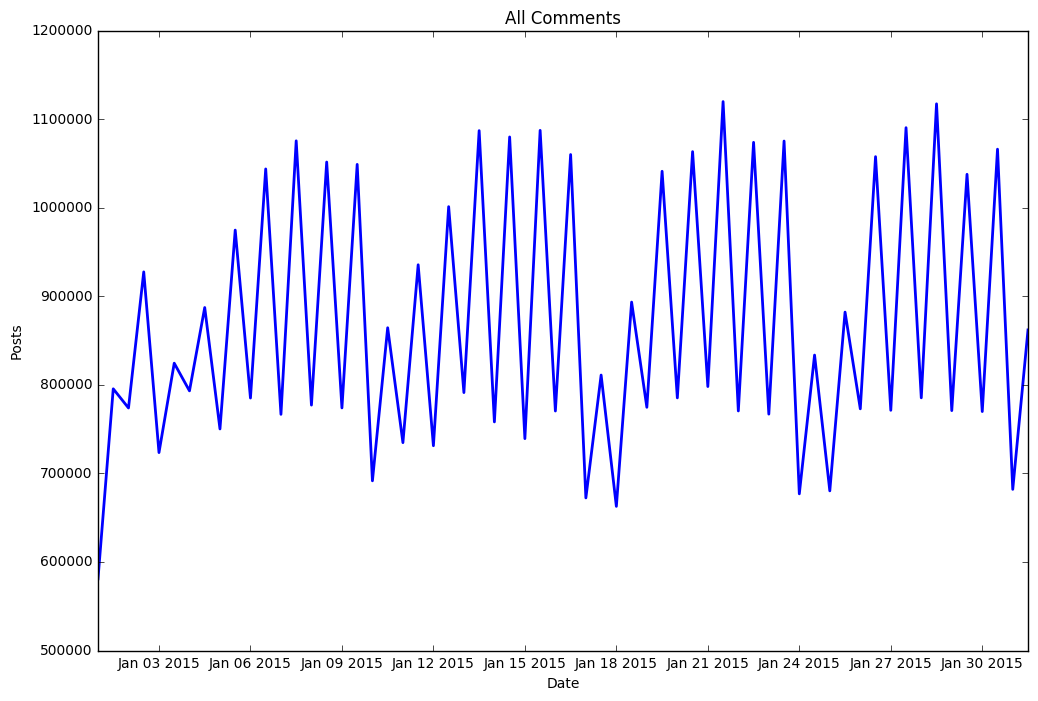

In [55]:
# Create a lineplot
plt.figure(num=1,figsize=(12, 8), dpi=80)
line, = plt.plot(counts_12h.index, counts_12h.values, lw=2)
plt.axis()
plt.xlabel('Date')
plt.ylabel('Posts')
plt.title('All Comments')
plt.show()

Each point of the above linegraph is the total number of posts within a 12 hour sequence between each point. It shows the difference on post frequence between the western and eastern hemisphere. Reddit is well known at the western hemisphere, that's why there is a big difference between two consecutive ponts. In addition one can see that every 10 points (5 days) there are 4 points with lower frequency. These are the weekends.

Now it is time to take a look at the body of each post

## Step 4 - Sentiment Analysis

The below list was generated by users on **Mechanical Turk**. It is a tab-delimited file named **Data Set S1**, with a set of 10,222 words, with information about their average happiness evaluations. The words are ordered according to average happiness (descending), and the file contains eight columns: (1) word, (2) rank, (3) average happiness (50 user evalutions), (4) standard deviation of happiness, (5) Twitter rank, (6) Google Books rank, (7) New York Times rank, (8) Music Lyrics rank. The last four columns correspond to the ranking of a word by frequency of occurrence in the top 5000 words for the specified corpus. A double dash ‘–’ indicates a word was not found in the most frequent 5000 words for a corpus.

Let's firstly take a look at the Data Set S1 file just to have an idea of what this is all about.

In [5]:
# Load first 5 lines of file
columns = ['word', 'happiness_rank', 'happiness_avg', 'happiness_std', 'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank']
happy_file = pd.read_csv('data/Data_Set_S1.txt', sep='\t', names=columns, encoding='latin-1')[1:]
happy_file.head()

word happiness_rank happiness_avg happiness_std twitter_rank  \
1   laughter              1          8.50        0.9313         3600   
2  happiness              2          8.44        0.9723         1853   
3       love              3          8.42        1.1082           25   
4      happy              4          8.30        0.9949           65   
5    laughed              5          8.26        1.1572         3334   

  google_rank nyt_rank lyrics_rank  
1          --       --        1728  
2        2458       --        1230  
3         317      328          23  
4        1372     1313         375  
5        3542       --        2332

In [17]:
# Change data type to numeric
happy_file[['happiness_avg']]= happy_file[['happiness_avg']].apply(
    pd.to_numeric)

In [30]:
# Happiness average value range
print 'happiness value range : { %f - %f } \nmean \t\t\t: { %f }'  % \
(happy_file.happiness_avg.min(),happy_file.happiness_avg.max(),
happy_file.happiness_avg.mean())

happiness value range : { 1.300000 - 8.500000 } 
mean 			: { 5.375240 }


Secondly we will create a dictionary which will be used as a mapper. Each key will be a word and each value, the average happiness ratio.

In [13]:
# Create happy_dictionary
happy_dict = {}
index = 1
for k in happy_file['word']:
    happy_dict[k] = happy_file['happiness_avg'][index]
    index +=1

Now that we have the mapper available let's go back to the reddit posts. We should collect all the bodies, pick the theme(subreddit) we like to analyze, clean its texts, tokenize them and create a big bag of words. Because castra is not supported anymore as a format, there have been some attempts to work with it but several errors came along so we decided to load the 33GB json file directly to dask bag. It is a bit slower but it works fine.

In [6]:
# Create a dask bag from castra file
bag = db.from_castra('reddit_data.castra/', columns=['subreddit', 'body'])
bag.take(1)

({'body': u'Most of us have some family members like this. *Most* of my family is like this. ',
  'subreddit': u'exmormon'},)

In [7]:
# Load 33GB file into a dask bag
jdata = db.from_filenames('data/RC_2015-01', chunkbytes=100000).map(json.loads)

# Show a sample of the first post
jdata.take(1)

/usr/local/lib/python2.7/site-packages/dask/bag/core.py:1089: UserWarning: db.from_filenames is deprecated in favor of db.read_text
  warn("db.from_filenames is deprecated in favor of db.read_text")


[########################################] | 100% Completed |  0.1s


({u'archived': False,
  u'author': u'YoungModern',
  u'author_flair_css_class': None,
  u'author_flair_text': None,
  u'body': u'Most of us have some family members like this. *Most* of my family is like this. ',
  u'controversiality': 0,
  u'created_utc': u'1420070400',
  u'distinguished': None,
  u'downs': 0,
  u'edited': False,
  u'gilded': 0,
  u'id': u'cnas8zv',
  u'link_id': u't3_2qyr1a',
  u'name': u't1_cnas8zv',
  u'parent_id': u't3_2qyr1a',
  u'retrieved_on': 1425124282,
  u'score': 14,
  u'score_hidden': False,
  u'subreddit': u'exmormon',
  u'subreddit_id': u't5_2r0gj',
  u'ups': 14},)

In [26]:
# Save files with subreddit 'worldnews'
matches_subreddit = bag.filter(lambda x: x['subreddit'] == 'trees')

# Collect only the bodies of posts
bodies = matches_subreddit.pluck('body').compute()

# Create a bag of tokens
#dirty_bag = bodies.map(nltk.word_tokenize).concat()

# Lower all characters in the bag
#lower_bag = dirty_bag.map(lambda x: x.lower())

# Clean bag from stopwords
#clean_bag = lower_bag.filter(lambda x: x not in stopwords.words('english'))

# keep only alphanumeric characters as words in the bag and remove NoneType
#bag_of_words = clean_bag.filter(lambda x: re.search("^[0-9a-zA-Z]+$", x) is not None)

In [25]:
print 'Processing..'
start = time.time()

# Keep all of the above in a variable in memory by using .compute()
bag_of_words = bag_of_words.compute()

end = time.time()
print "The bag of words has been created in: %s" % str(datetime.timedelta(seconds=(end-start)))

Processing..


TypeError: expected string or buffer

Traceback
---------
  File "/usr/local/lib/python2.7/site-packages/dask/async.py", line 267, in execute_task
    result = _execute_task(task, data)
  File "/usr/local/lib/python2.7/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/usr/local/lib/python2.7/site-packages/dask/bag/core.py", line 1338, in reify
    seq = list(seq)
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/__init__.py", line 106, in word_tokenize
    return [token for sent in sent_tokenize(text, language)
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/__init__.py", line 91, in sent_tokenize
    return tokenizer.tokenize(text)
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 1226, in tokenize
    return list(self.sentences_from_text(text, realign_boundaries))
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 1274, in sentences_from_text
    return [text[s:e] for s, e in self.span_tokenize(text, realign_boundaries)]
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 1265, in span_tokenize
    return [(sl.start, sl.stop) for sl in slices]
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 1304, in _realign_boundaries
    for sl1, sl2 in _pair_iter(slices):
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 310, in _pair_iter
    prev = next(it)
  File "/usr/local/lib/python2.7/site-packages/nltk/tokenize/punkt.py", line 1278, in _slices_from_text
    for match in self._lang_vars.period_context_re().finditer(text):


In [20]:
# Save bag_of_words to a file to release cache memory usage
with open('data/bag_of_words.csv', 'w') as f:
    for item in bag_of_words:
        f.write("%s\n" % item)

In [27]:
# Load the file again
with open('data/bag_of_words.csv', 'r') as f:
    bag_of_words = [item[:-1] for item in f]        

In [5]:
# There are 11.5 million words in this bag
len(bag_of_words)

11660771

Now that we have a bag of words, we can create the functions that will iterate in each word, check the happiness_avg if there is any, create a sliding windows of 10,50 and 500 words, and check the sentiment results


In [6]:
def happy_meter(tokens):
    # Check if tokens match happy_dict
    counter = 0
    total_ratio = 0
    for i in happy_dict.keys():
        for token in tokens:
            if token in i:
                counter+=1
                total_ratio+=float(happy_dict[i])
    
    # print 'Happiness ratio range is (1.30 - 8.50)'
    if counter == 0:
        return 0 #'There are no words with sentiment attached'
    else:
        return total_ratio/counter #'The happiness ratio of this text is: {0:.2f}'.format(total_ratio/counter) 

In [7]:
def sentimentizer(bag,n):

    # Create buckets of words
    buckets = izip(*[iter(bag)]*n)
    
    # Calculate sentiment of each bucket and assign values to new dictionary
    counter = 1
    ratio = []
    word_counter = []
    for bucket in buckets:
        ratio.append(happy_meter(list(bucket))) 
        word_counter.append(n*counter)
        counter+=1
    
    # Create a lineplot for sentiment profile
    plt.figure(num=1,figsize=(12, 8), dpi=80)
    line, = plt.plot(count_12h.index, ratio, lw=2)
    plt.axis()
    plt.xlabel('Date')
    plt.ylabel('Happiness Ratio')
    plt.title('Sentiment Profile')
    plt.show()

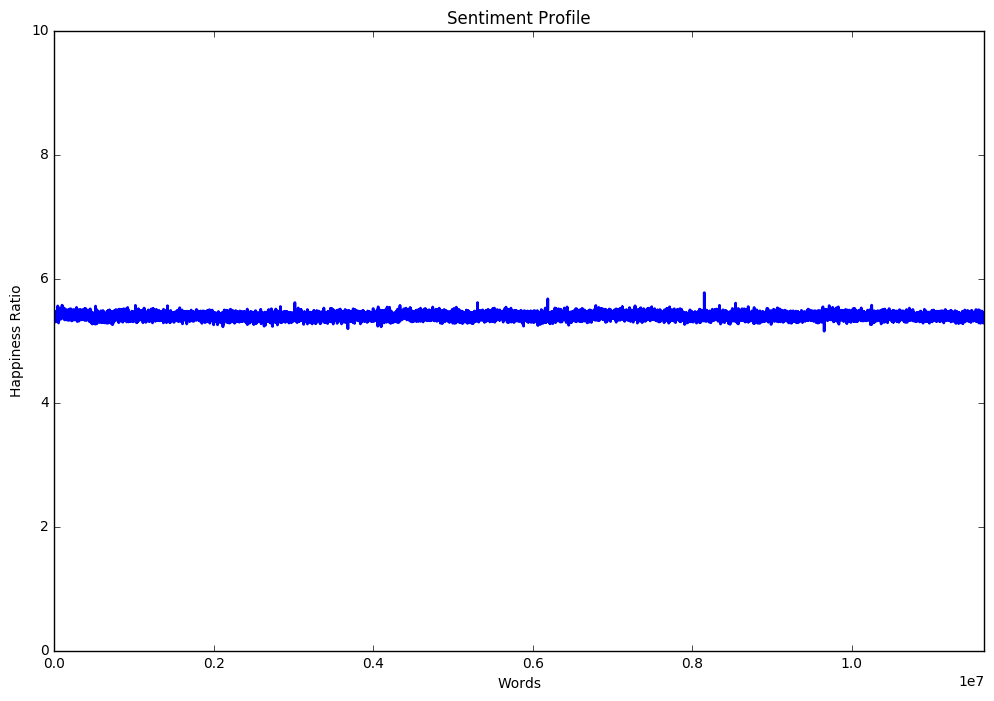

In [37]:
# Create profiles for sliding windows of length 500 words, 50000 words, 500000 words
# It takes almost 4 hours to run
sentimentizer(bag_of_words,500)


On average, one can tell that January 2015 was generally a neutral month in terms of happiness as it is close to 5.5 which is the mean. But we can see some happier peaks (close to 6) on January 20th. If we had used a sliding window of 50 words, we would have a higher range of values but in order to see the differences in time we should zoom-in the plot. If we have took a bigger sliding window (12 hours) we would have seen a strait line close to 5.5.

## Step 5 - Word Cloud

Now we will create a word cloud based on the bag of words with subreddit **'worldnews'**

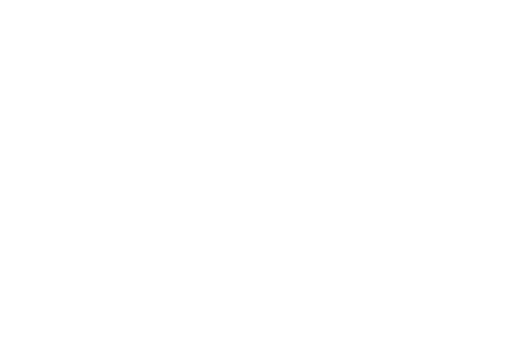

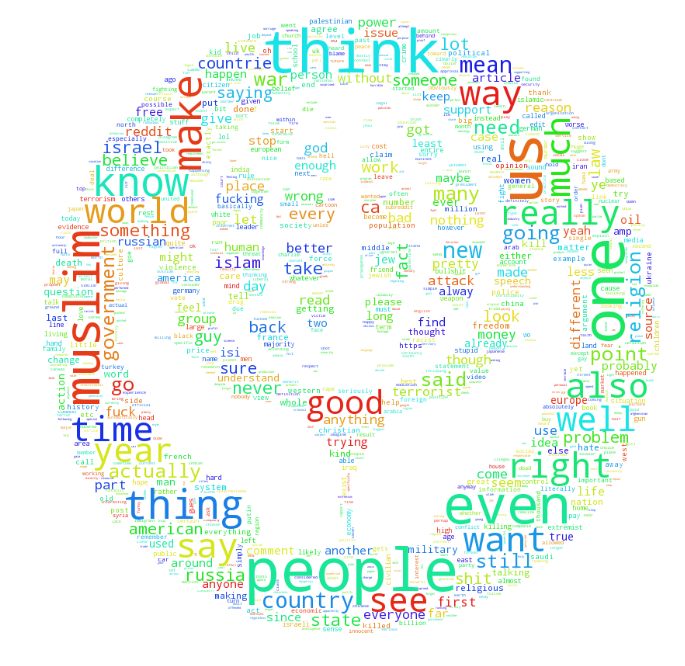

In [36]:
# Create a function that turns the bag_of_words into a string
def generate_string(bag):
    s = ''
    s+=' '.join([word for word in bag])
    return s

# Generate string from bag_of_words
s = generate_string(bag_of_words)

# Exclude some more from the cloud
stopwords = {'deleted', 'gt'}
STOPWORDS = STOPWORDS.union(stopwords)

# Create a mask as a stencil for the word cloud
world_mask = imread('photos/world_3.jpg',flatten=True)

# Set requirements for the bag_of_words
wc = WordCloud(background_color="white", max_words=2000, width=1800, height=1400, mask=world_mask,
              stopwords=STOPWORDS)

# Generate the word cloud by sourcing the string
wc.generate(s)

# Show
#plt.imshow(wc)
plt.axis("off")
plt.savefig('photos/world_cloud.png', dpi=300)
plt.figure(figsize=(12,8),dpi=500)
img=plt.imshow(wc)
#plt.imshow(world_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

## Step 6 - Machine Learning